### Lab-09_3: Dropout

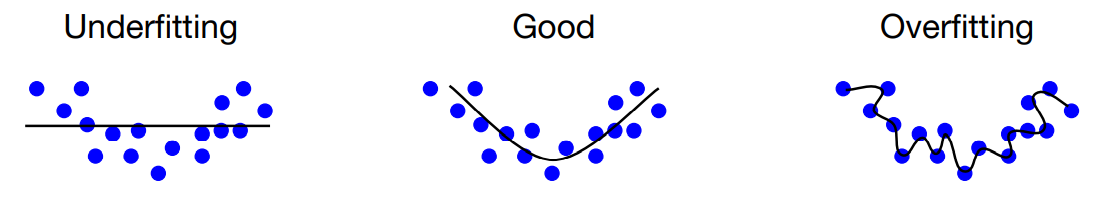

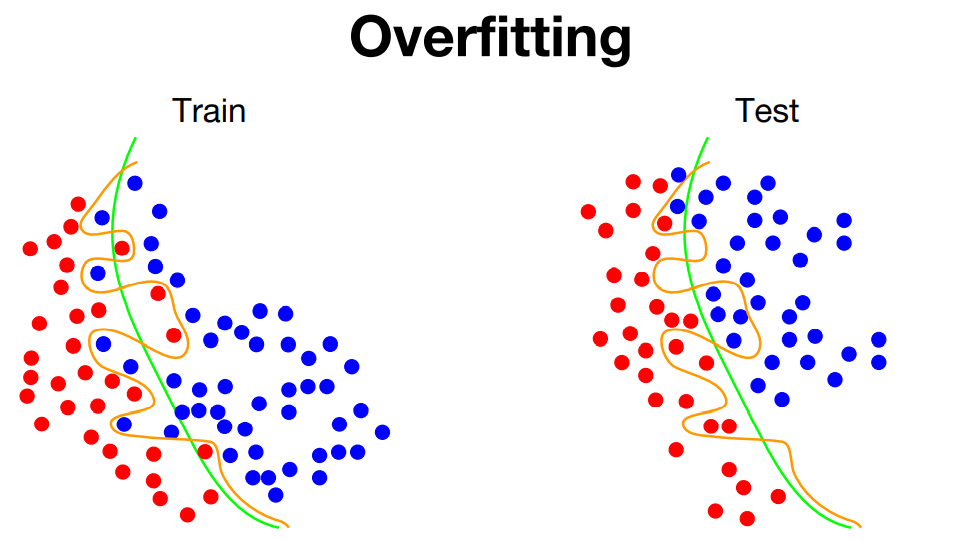

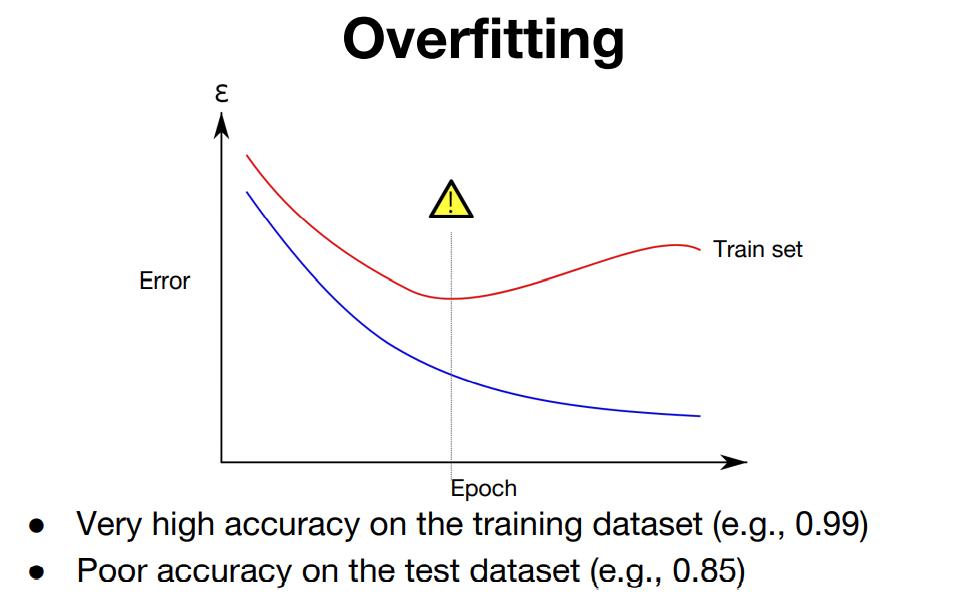

- 규제의 일종인 Dropout을 적용해보자!

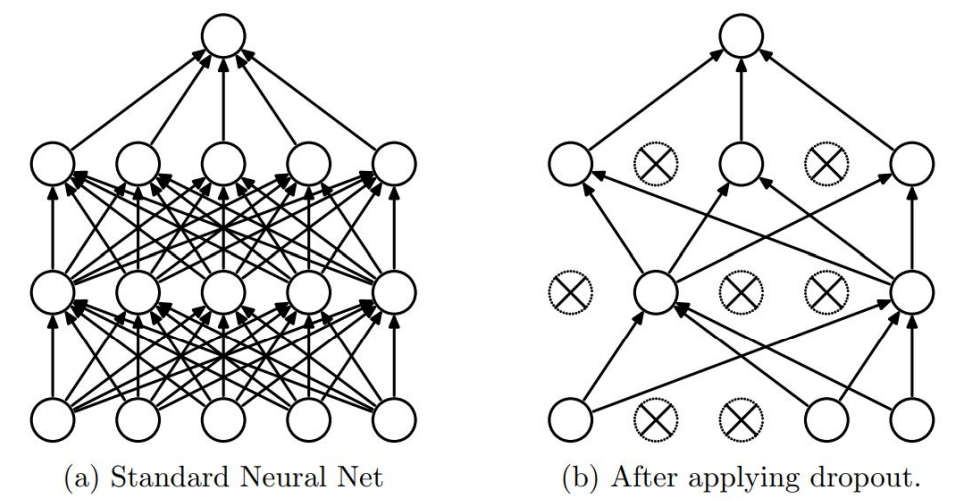

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob) # 학습시, 해당 Layer의 node들 중 몇 %를 사용하지 않을지! 

# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

In [ ]:
# model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device) # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True) -> 주의!
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

In [ ]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False) -> 주의!
    # test set을 사용할 때는 모든 node를 사용! 

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

### Lab-09_4: Batch Normalization

- Gradient Vanishing/ Exploding
  - Solution
    - Change activation function
    - Careful initialization
    - Small learning rate
    - Batch Normalization !! -> 직접적인 해결

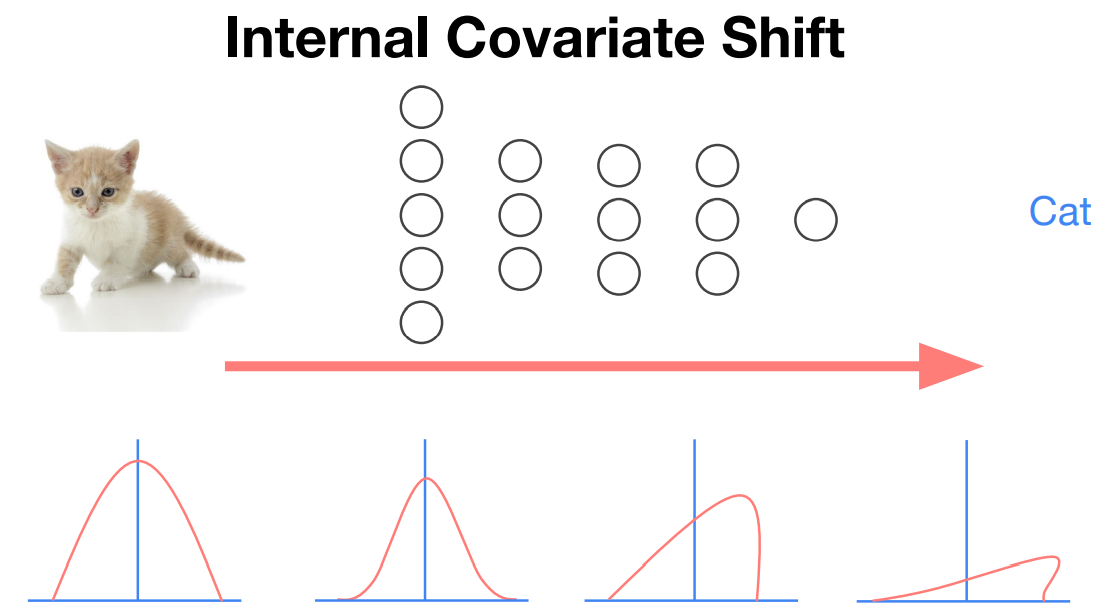

- Layer 를 거칠수록 입력과 출력의 분포가 달라지는 Covariate Shift 문제 발생 !!
  - Layer 가 많아질수록 심해짐 -> Batch Normalization 사용 !!
    - 아래의 수식에서 입실론은 분모가 0 이 되는 것을 막는 역할 
    - 감마와 베타는 학습을 통해 계속 개선됨 -> Backpropagation
  - Train & eval mode 를 구별해서 사용 (Dropout과 유사)
    - Batch Normalization 이 적용되는 Layer 에 test 입력이 들어가면...
      - x -> x', 감마와 베타를 통해 출력 변형 
      - ex) 배치 사이즈 8 가정, 배치에서 끝단 2개의 데이터만 다른 데이터로 변경시 평균과 분산이 달라짐 -> 이처럼 학습 당시와 다른 결과 !!
      - 그러므로 우리는 학습 때의 평균과 분산을 저장해두고 테스트시 이를 그대로 사용 !! (Learning mean & variance 저장)    

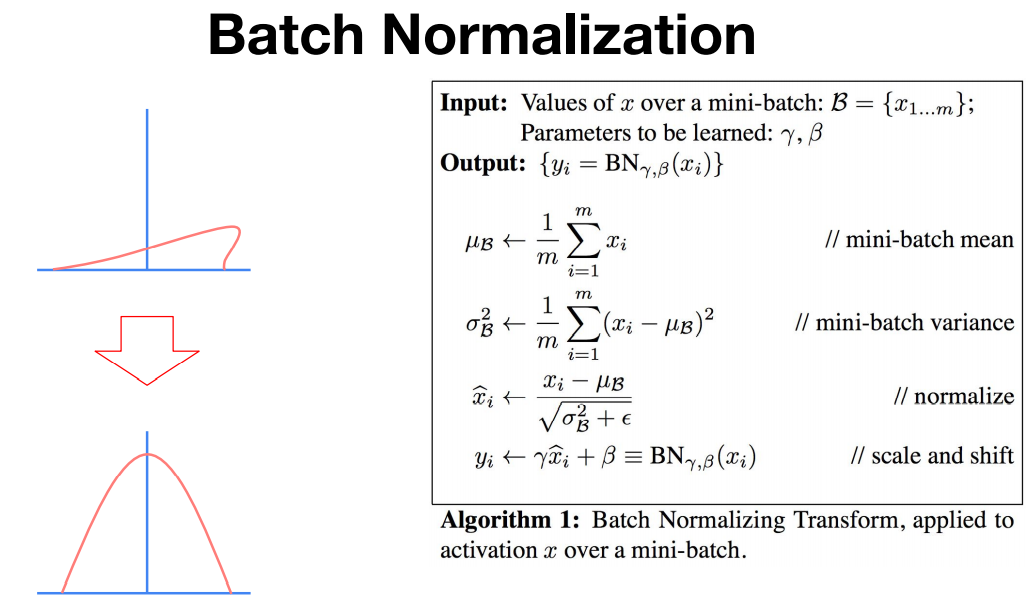

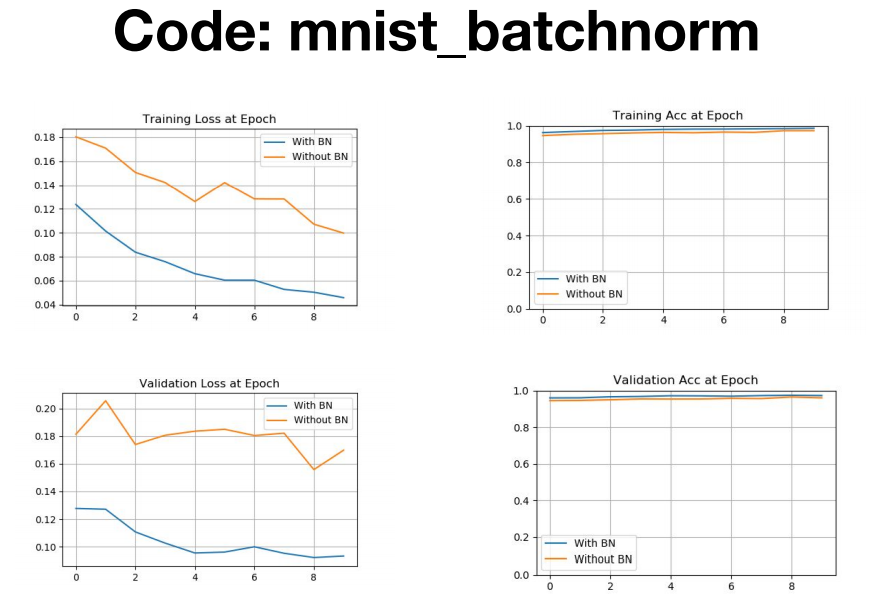

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [ ]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [ ]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

# model -> Batch Normalization 을 적용한 모델과 적용하지 않은 모델 생성
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [ ]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

##### 결과 비교

In [ ]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

In [ ]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')